<a href="https://colab.research.google.com/github/kcw0331/Environmental-Health-Big-Data-Analysis/blob/main/7%EC%A3%BC%EC%B0%A8/3-cleaning_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cleaning Data

## About the data
In this notebook, we will using daily temperature data from the [National Centers for Environmental Information (NCEI) API](https://www.ncdc.noaa.gov/cdo-web/webservices/v2). We will use the Global Historical Climatology Network - Daily (GHCND) dataset; see the documentation [here](https://www1.ncdc.noaa.gov/pub/data/cdo/documentation/GHCND_documentation.pdf).

This data was collected from the LaGuardia Airport station in New York City for October 2018. It contains:
- the daily minimum temperature (`TMIN`)
- the daily maximum temperature (`TMAX`)
- the daily average temperature (`TAVG`)

*Note: The NCEI is part of the National Oceanic and Atmospheric Administration (NOAA) and, as you can see from the URL for the API, this resource was created when the NCEI was called the NCDC. Should the URL for this resource change in the future, you can search for "NCEI weather API" to find the updated one.*

In addition, we will be using S&P 500 stock market data (obtained using the [`stock_analysis`](https://github.com/stefmolin/stock-analysis) package we will build in chapter 7) and data for bitcoin for 2017 through 2018. For the first edition, the bitcoin data was collected from CoinMarketCap using the `stock_analysis` package; however, changes in the website led to the necessity of changing the data source to Yahoo! Finance. The bitcoin data that was collected before the CoinMarketCap website change should be equivalent to the historical data that can be viewed on [this](https://coinmarketcap.com/currencies/bitcoin/historical-data/) page.

## Setup
We need to import `pandas` and read in the temperature data to get started:

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
cd /content/drive/MyDrive/Hands-On-Data-Analysis-with-Pandas-2nd-edition/ch_03

/content/drive/MyDrive/Hands-On-Data-Analysis-with-Pandas-2nd-edition/ch_03


In [4]:
import pandas as pd

df = pd.read_csv('data/nyc_temperatures.csv')
df.head()

,date,datatype,station,attributes,value
0,2018-10-01T00:00:00,TAVG,GHCND:USW00014732,"H,,S,",21.2
1,2018-10-01T00:00:00,TMAX,GHCND:USW00014732,",,W,2400",25.6
2,2018-10-01T00:00:00,TMIN,GHCND:USW00014732,",,W,2400",18.3
3,2018-10-02T00:00:00,TAVG,GHCND:USW00014732,"H,,S,",22.7
4,2018-10-02T00:00:00,TMAX,GHCND:USW00014732,",,W,2400",26.1


* value가 temperatures in 도시이다.
* attributes는 어디에서 수집했는지에 대한 정보이다.

## Renaming Columns
We start out with the following columns:

In [5]:
df.columns

Index(['date', 'datatype', 'station', 'attributes', 'value'], dtype='object')

We want to rename the `value` column to indicate it contains the temperature in Celsius and the `attributes` column to say `flags` since each value in the comma-delimited string is a different flag about the data collection. For this task, we use the `rename()` method and pass in a dictionary mapping the column names to their new names. We pass `inplace=True` to change our original dataframe instead of getting a new one back:

In [6]:
df.rename(
    columns={
        'value': 'temp_C',
        'attributes': 'flags'
    }, inplace=True
)

* value를 temp_C로 바꾸어 주었고, attributes는 flags로 바꾸어 주었다.
* inplace는 True로 해서 바뀐 정보가 df에 저장이 되도록 해준다.

Those columns have been successfully renamed:

In [7]:
df.columns

Index(['date', 'datatype', 'station', 'flags', 'temp_C'], dtype='object')

* 다시 df.colums을 쳐보면 바뀌 정보가 나오는 것을 확인할 수 있다.

We can also perform string operations on the column names with `rename()`:

In [8]:
df.rename(str.upper, axis='columns').columns

Index(['DATE', 'DATATYPE', 'STATION', 'FLAGS', 'TEMP_C'], dtype='object')

* 변수를 대문자로 바꾸고 싶으면 str.upper를 사용하면 된다.

## Type Conversion
The `date` column is not currently being stored as a `datetime`:

In [9]:
df.dtypes

date         object
datatype     object
station      object
flags        object
temp_C      float64
dtype: object

* date가 일반 object형식으로 되어 있는데 이걸 datetime64형식으로 바꾸어준다.

Let's perform the conversion with `pd.to_datetime()`:

In [10]:
df.loc[:,'date'] = pd.to_datetime(df.date)
df.dtypes

date        datetime64[ns]
datatype            object
station             object
flags               object
temp_C             float64
dtype: object

Now we get useful information when we use `describe()` on this column:

In [11]:
df.date.describe(datetime_is_numeric=True)

count                     93
mean     2018-10-16 00:00:00
min      2018-10-01 00:00:00
25%      2018-10-08 00:00:00
50%      2018-10-16 00:00:00
75%      2018-10-24 00:00:00
max      2018-10-31 00:00:00
Name: date, dtype: object

* datetime으로 바꾸어 주고 describe를 하게 되면 그 datetime에 대한 정보들이 나오는 것을 볼 수 있다.

We can use `tz_localize()` on a `DatetimeIndex` object to convert to a desired timezone:

In [12]:
pd.date_range(start='2018-10-25', periods=2, freq='D').tz_localize('EST')

DatetimeIndex(['2018-10-25 00:00:00-05:00', '2018-10-26 00:00:00-05:00'], dtype='datetime64[ns, EST]', freq=None)

* tz_localize를 이용해서 timezone을 명시해 줄 수 있다.
* 다른 나라들과 timezone을 일치 시킬 때 유용하게 사용된다.
* datetime을 사용할 때 timezone을 공부해보는게 좋다고 하심.

This also works with `Series`/`DataFrame` objects that have an index of type `DatetimeIndex`. Let's read in the CSV again for this example and set the `date` column to be the index and stored as a datetime:

In [13]:
eastern = pd.read_csv(
    'data/nyc_temperatures.csv', index_col='date', parse_dates=True
).tz_localize('EST')
eastern.head()

,datatype,station,attributes,value
date,,,,
2018-10-01 00:00:00-05:00,TAVG,GHCND:USW00014732,"H,,S,",21.2
2018-10-01 00:00:00-05:00,TMAX,GHCND:USW00014732,",,W,2400",25.6
2018-10-01 00:00:00-05:00,TMIN,GHCND:USW00014732,",,W,2400",18.3
2018-10-02 00:00:00-05:00,TAVG,GHCND:USW00014732,"H,,S,",22.7
2018-10-02 00:00:00-05:00,TMAX,GHCND:USW00014732,",,W,2400",26.1


* 이거와 같은 경우는 데이터를 읽어 올 때, timzone을 사용해서 읽어오는 방법이다.

We can use `tz_convert()` to convert to another timezone from there. If we convert the Eastern datetimes to UTC, they will now be at 5 AM, since `pandas` will use the offsets to convert:

In [14]:
eastern.tz_convert('UTC').head()

,datatype,station,attributes,value
date,,,,
2018-10-01 05:00:00+00:00,TAVG,GHCND:USW00014732,"H,,S,",21.2
2018-10-01 05:00:00+00:00,TMAX,GHCND:USW00014732,",,W,2400",25.6
2018-10-01 05:00:00+00:00,TMIN,GHCND:USW00014732,",,W,2400",18.3
2018-10-02 05:00:00+00:00,TAVG,GHCND:USW00014732,"H,,S,",22.7
2018-10-02 05:00:00+00:00,TMAX,GHCND:USW00014732,",,W,2400",26.1


* timezone을 바꾸고 싶을 때는 tz_convert를 사용해서 timezone을 바꾸어 줄 수 있다.

We can change the period of the index as well. We could change the period to be monthly to make it easier to aggregate later. (Aggregation will be discussed in chapter 4.)

In [15]:
eastern.tz_localize(None).to_period('M').index

PeriodIndex(['2018-10', '2018-10', '2018-10', '2018-10', '2018-10', '2018-10',
             '2018-10', '2018-10', '2018-10', '2018-10', '2018-10', '2018-10',
             '2018-10', '2018-10', '2018-10', '2018-10', '2018-10', '2018-10',
             '2018-10', '2018-10', '2018-10', '2018-10', '2018-10', '2018-10',
             '2018-10', '2018-10', '2018-10', '2018-10', '2018-10', '2018-10',
             '2018-10', '2018-10', '2018-10', '2018-10', '2018-10', '2018-10',
             '2018-10', '2018-10', '2018-10', '2018-10', '2018-10', '2018-10',
             '2018-10', '2018-10', '2018-10', '2018-10', '2018-10', '2018-10',
             '2018-10', '2018-10', '2018-10', '2018-10', '2018-10', '2018-10',
             '2018-10', '2018-10', '2018-10', '2018-10', '2018-10', '2018-10',
             '2018-10', '2018-10', '2018-10', '2018-10', '2018-10', '2018-10',
             '2018-10', '2018-10', '2018-10', '2018-10', '2018-10', '2018-10',
             '2018-10', '2018-10', '2018-10', '2018-

* timezone에서 Moth까지의 정보만 가지고 올 때 사용해준다.

We now get a `PeriodIndex` object, which we can change back into a `DatetimeIndex` object with `to_timestamp()`:

In [16]:
eastern.tz_localize(None).to_period('M').to_timestamp().index

DatetimeIndex(['2018-10-01', '2018-10-01', '2018-10-01', '2018-10-01',
               '2018-10-01', '2018-10-01', '2018-10-01', '2018-10-01',
               '2018-10-01', '2018-10-01', '2018-10-01', '2018-10-01',
               '2018-10-01', '2018-10-01', '2018-10-01', '2018-10-01',
               '2018-10-01', '2018-10-01', '2018-10-01', '2018-10-01',
               '2018-10-01', '2018-10-01', '2018-10-01', '2018-10-01',
               '2018-10-01', '2018-10-01', '2018-10-01', '2018-10-01',
               '2018-10-01', '2018-10-01', '2018-10-01', '2018-10-01',
               '2018-10-01', '2018-10-01', '2018-10-01', '2018-10-01',
               '2018-10-01', '2018-10-01', '2018-10-01', '2018-10-01',
               '2018-10-01', '2018-10-01', '2018-10-01', '2018-10-01',
               '2018-10-01', '2018-10-01', '2018-10-01', '2018-10-01',
               '2018-10-01', '2018-10-01', '2018-10-01', '2018-10-01',
               '2018-10-01', '2018-10-01', '2018-10-01', '2018-10-01',
      

* 그리고 to_timestap으로 바꾸어 주게 되면 년 월 일에 대한 정보가 나오게 된다.

We can use the `assign()` method for working with multiple columns at once (or creating new ones). Since our `date` column has already been converted, we need to read in the data again:

In [17]:
df = pd.read_csv('data/nyc_temperatures.csv').rename(
    columns={
        'value': 'temp_C',
        'attributes': 'flags'
    }
)

new_df = df.assign(
    date=pd.to_datetime(df.date),
    temp_F=(df.temp_C * 9/5) + 32
)
new_df.dtypes

date        datetime64[ns]
datatype            object
station             object
flags               object
temp_C             float64
temp_F             float64
dtype: object

* 이 부분과 같은 경우는 assing을 활용해서 date와 temp_F의 새로운 변수를 만들어 주는 것이다.

The `date` column now has datetimes and the `temp_F` column was added:

In [18]:
new_df.head()

,date,datatype,station,flags,temp_C,temp_F
0,2018-10-01,TAVG,GHCND:USW00014732,"H,,S,",21.2,70.16
1,2018-10-01,TMAX,GHCND:USW00014732,",,W,2400",25.6,78.08
2,2018-10-01,TMIN,GHCND:USW00014732,",,W,2400",18.3,64.94
3,2018-10-02,TAVG,GHCND:USW00014732,"H,,S,",22.7,72.86
4,2018-10-02,TMAX,GHCND:USW00014732,",,W,2400",26.1,78.98


We can also use `astype()` to perform conversions. Let's create columns of the integer portion of the temperatures in Celsius and Fahrenheit. We will use **lambda functions** (first introduced in *Chapter 2, Working with Pandas DataFrames*), so that we can use the values being created in the `temp_F` column to calculate the `temp_F_whole` column. It is very common (and useful) to use lambda functions with `assign()`:

In [19]:
df = df.assign(
    date=lambda x: pd.to_datetime(x.date),
    temp_C_whole=lambda x: x.temp_C.astype('int'),
    temp_F=lambda x: (x.temp_C * 9/5) + 32,
    temp_F_whole=lambda x: x.temp_F.astype('int')
)

df.head()

,date,datatype,station,flags,temp_C,temp_C_whole,temp_F,temp_F_whole
0,2018-10-01,TAVG,GHCND:USW00014732,"H,,S,",21.2,21,70.16,70
1,2018-10-01,TMAX,GHCND:USW00014732,",,W,2400",25.6,25,78.08,78
2,2018-10-01,TMIN,GHCND:USW00014732,",,W,2400",18.3,18,64.94,64
3,2018-10-02,TAVG,GHCND:USW00014732,"H,,S,",22.7,22,72.86,72
4,2018-10-02,TMAX,GHCND:USW00014732,",,W,2400",26.1,26,78.98,78


* 여기에서는 x 타입으로 해서 integer 형식으로 바꾸어 준다.

Creating categories:

In [20]:
df_with_categories = df.assign(
    station=df.station.astype('category'),
    datatype=df.datatype.astype('category')
)
df_with_categories.dtypes

date            datetime64[ns]
datatype              category
station               category
flags                   object
temp_C                 float64
temp_C_whole             int64
temp_F                 float64
temp_F_whole             int64
dtype: object

* datatype과 station을 category형식으로 바꾸어 줄 때 astype을 사용해서 바꾸어 줄 수 있다.

In [21]:
df_with_categories.describe(include='category')

,datatype,station
count,93,93
unique,3,1
top,TMIN,GHCND:USW00014732
freq,31,93


* catefory를 만든 것을 describe를 하게 되면 그거에 대한 정보를 확인해 줄 수 있다.

Our categories have no order, but this is something that `pandas` supports:

In [22]:
pd.Categorical(
    ['med', 'med', 'low', 'high'], 
    categories=['low', 'med', 'high'],
    ordered=True
)

['med', 'med', 'low', 'high']
Categories (3, object): ['low' < 'med' < 'high']

* categorical variable과 같은 경우는 pandas에서 oredering이 support가 된다.

## Reordering, reindexing, and sorting
Say we want to find the days that reached the hottest temperatures in the weather data; we can sort our values by the `temp_C` column with the largest on top to find this: 

In [23]:
df[df.datatype == 'TMAX'].sort_values(by='temp_C', ascending=False).head(10)

,date,datatype,station,flags,temp_C,temp_C_whole,temp_F,temp_F_whole
19,2018-10-07,TMAX,GHCND:USW00014732,",,W,2400",27.8,27,82.04,82
28,2018-10-10,TMAX,GHCND:USW00014732,",,W,2400",27.8,27,82.04,82
31,2018-10-11,TMAX,GHCND:USW00014732,",,W,2400",26.7,26,80.06,80
10,2018-10-04,TMAX,GHCND:USW00014732,",,W,2400",26.1,26,78.98,78
4,2018-10-02,TMAX,GHCND:USW00014732,",,W,2400",26.1,26,78.98,78
1,2018-10-01,TMAX,GHCND:USW00014732,",,W,2400",25.6,25,78.08,78
25,2018-10-09,TMAX,GHCND:USW00014732,",,W,2400",25.6,25,78.08,78
7,2018-10-03,TMAX,GHCND:USW00014732,",,W,2400",25.0,25,77.00,77
13,2018-10-05,TMAX,GHCND:USW00014732,",,W,2400",22.8,22,73.04,73
22,2018-10-08,TMAX,GHCND:USW00014732,",,W,2400",22.8,22,73.04,73


* 무엇을 사용할지와 오름차순 내림차순으로해서 지정 해 줄 수 있다.

However, this isn't perfect because we have some ties, and they aren't sorted consistently. In the first tie between the 7th and the 10th, the earlier date comes first, but the opposite is true with the tie between the 4th and the 2nd. We can use other columns to break ties and specify how to sort each with `ascending`. Let's break ties with the date column and show earlier dates before later ones:

In [24]:
df[df.datatype == 'TMAX'].sort_values(by=['temp_C', 'date'], ascending=[False, True]).head(10)

,date,datatype,station,flags,temp_C,temp_C_whole,temp_F,temp_F_whole
19,2018-10-07,TMAX,GHCND:USW00014732,",,W,2400",27.8,27,82.04,82
28,2018-10-10,TMAX,GHCND:USW00014732,",,W,2400",27.8,27,82.04,82
31,2018-10-11,TMAX,GHCND:USW00014732,",,W,2400",26.7,26,80.06,80
4,2018-10-02,TMAX,GHCND:USW00014732,",,W,2400",26.1,26,78.98,78
10,2018-10-04,TMAX,GHCND:USW00014732,",,W,2400",26.1,26,78.98,78
1,2018-10-01,TMAX,GHCND:USW00014732,",,W,2400",25.6,25,78.08,78
25,2018-10-09,TMAX,GHCND:USW00014732,",,W,2400",25.6,25,78.08,78
7,2018-10-03,TMAX,GHCND:USW00014732,",,W,2400",25.0,25,77.00,77
13,2018-10-05,TMAX,GHCND:USW00014732,",,W,2400",22.8,22,73.04,73
22,2018-10-08,TMAX,GHCND:USW00014732,",,W,2400",22.8,22,73.04,73


* by에 두개를 하게 되면 sequencial하게 지정해 줄 수 있다.

Notice that the index was jumbled in the past 2 results. Here, our index only stores the row number in the original data, but we may not need to keep track of that information. In this case, we can pass in `ignore_index=True` to get a new index after sorting:

In [25]:
df[df.datatype == 'TMAX'].sort_values(by=['temp_C', 'date'], ascending=[False, True], ignore_index=True).head(10)

,date,datatype,station,flags,temp_C,temp_C_whole,temp_F,temp_F_whole
0,2018-10-07,TMAX,GHCND:USW00014732,",,W,2400",27.8,27,82.04,82
1,2018-10-10,TMAX,GHCND:USW00014732,",,W,2400",27.8,27,82.04,82
2,2018-10-11,TMAX,GHCND:USW00014732,",,W,2400",26.7,26,80.06,80
3,2018-10-02,TMAX,GHCND:USW00014732,",,W,2400",26.1,26,78.98,78
4,2018-10-04,TMAX,GHCND:USW00014732,",,W,2400",26.1,26,78.98,78
5,2018-10-01,TMAX,GHCND:USW00014732,",,W,2400",25.6,25,78.08,78
6,2018-10-09,TMAX,GHCND:USW00014732,",,W,2400",25.6,25,78.08,78
7,2018-10-03,TMAX,GHCND:USW00014732,",,W,2400",25.0,25,77.00,77
8,2018-10-05,TMAX,GHCND:USW00014732,",,W,2400",22.8,22,73.04,73
9,2018-10-08,TMAX,GHCND:USW00014732,",,W,2400",22.8,22,73.04,73


When just looking for the n-largest values, rather than wanting to sort all the data, we can use `nlargest()`:

In [26]:
df[df.datatype == 'TAVG'].nlargest(n=10, columns='temp_C')

,date,datatype,station,flags,temp_C,temp_C_whole,temp_F,temp_F_whole
27,2018-10-10,TAVG,GHCND:USW00014732,"H,,S,",23.8,23,74.84,74
30,2018-10-11,TAVG,GHCND:USW00014732,"H,,S,",23.4,23,74.12,74
18,2018-10-07,TAVG,GHCND:USW00014732,"H,,S,",22.8,22,73.04,73
3,2018-10-02,TAVG,GHCND:USW00014732,"H,,S,",22.7,22,72.86,72
6,2018-10-03,TAVG,GHCND:USW00014732,"H,,S,",21.8,21,71.24,71
24,2018-10-09,TAVG,GHCND:USW00014732,"H,,S,",21.8,21,71.24,71
9,2018-10-04,TAVG,GHCND:USW00014732,"H,,S,",21.3,21,70.34,70
0,2018-10-01,TAVG,GHCND:USW00014732,"H,,S,",21.2,21,70.16,70
21,2018-10-08,TAVG,GHCND:USW00014732,"H,,S,",20.9,20,69.62,69
12,2018-10-05,TAVG,GHCND:USW00014732,"H,,S,",20.3,20,68.54,68


* lagest value를 하게 되면 temp_C기준으로 10개의 것을 볼 수 있다.

We use `nsmallest()` for the n-smallest values.

In [27]:
df.nsmallest(n=5, columns=['temp_C', 'date'])

,date,datatype,station,flags,temp_C,temp_C_whole,temp_F,temp_F_whole
65,2018-10-22,TMIN,GHCND:USW00014732,",,W,2400",5.6,5,42.08,42
77,2018-10-26,TMIN,GHCND:USW00014732,",,W,2400",5.6,5,42.08,42
62,2018-10-21,TMIN,GHCND:USW00014732,",,W,2400",6.1,6,42.98,42
74,2018-10-25,TMIN,GHCND:USW00014732,",,W,2400",6.1,6,42.98,42
53,2018-10-18,TMIN,GHCND:USW00014732,",,W,2400",6.7,6,44.06,44


* 작은거 기준으로 나열하는 기준도 있다.

The `sample()` method will give us rows (or columns with `axis=1`) at random. We can provide a seed (`random_state`) to make this reproducible. The index after we do this is jumbled:

In [28]:
df.sample(5, random_state=0).index

Int64Index([2, 30, 55, 16, 13], dtype='int64')

We can use `sort_index()` to order it again:

In [29]:
df.sample(5, random_state=0).sort_index().index

Int64Index([2, 13, 16, 30, 55], dtype='int64')

* index를 sort하고 싶을 때는 sort_index를 해줘서 index를 sort해 줄 수 있다.

The `sort_index()` method can also sort columns alphabetically:

In [30]:
df.sort_index(axis=1).head()

,datatype,date,flags,station,temp_C,temp_C_whole,temp_F,temp_F_whole
0,TAVG,2018-10-01,"H,,S,",GHCND:USW00014732,21.2,21,70.16,70
1,TMAX,2018-10-01,",,W,2400",GHCND:USW00014732,25.6,25,78.08,78
2,TMIN,2018-10-01,",,W,2400",GHCND:USW00014732,18.3,18,64.94,64
3,TAVG,2018-10-02,"H,,S,",GHCND:USW00014732,22.7,22,72.86,72
4,TMAX,2018-10-02,",,W,2400",GHCND:USW00014732,26.1,26,78.98,78


* columns 이름으로 sort를 해줄 수 있는데 이럴 때는 axis를 1로 해줘야 된다.

This can make selection with `loc` easier for many columns:

* sort를 해줌으로써 여러개의 column을 선택할 때 더 유용할 수 있다는 것이다.

In [31]:
df.sort_index(axis=1).head().loc[:,'temp_C':'temp_F_whole']

,temp_C,temp_C_whole,temp_F,temp_F_whole
0,21.2,21,70.16,70
1,25.6,25,78.08,78
2,18.3,18,64.94,64
3,22.7,22,72.86,72
4,26.1,26,78.98,78


We must sort the index to compare two dataframes. If the index is different, but the data is the same, they will be marked not-equal:

In [32]:
df.equals(df.sort_values(by='temp_C'))

False

Sorting the index solves this issue:

In [33]:
df.equals(df.sort_values(by='temp_C').sort_index())

True

Let's set the `date` column as our index:

In [34]:
df.set_index('date', inplace=True)
df.head()

,datatype,station,flags,temp_C,temp_C_whole,temp_F,temp_F_whole
date,,,,,,,
2018-10-01,TAVG,GHCND:USW00014732,"H,,S,",21.2,21,70.16,70
2018-10-01,TMAX,GHCND:USW00014732,",,W,2400",25.6,25,78.08,78
2018-10-01,TMIN,GHCND:USW00014732,",,W,2400",18.3,18,64.94,64
2018-10-02,TAVG,GHCND:USW00014732,"H,,S,",22.7,22,72.86,72
2018-10-02,TMAX,GHCND:USW00014732,",,W,2400",26.1,26,78.98,78


* 날짜를 index로 하고 싶을 때는 set_index로 해서 inplace는 True로 해주면 날짜 관련해서 index로 바꾸어 줄 수 있다.

Now that we have an index of type `DatetimeIndex`, we can do datetime slicing and indexing. As long as we provide a date format that pandas understands, we can grab the data. To select all of 2018, we simply use `df.loc['2018']`, for the fourth quarter of 2018 we can use `df.loc['2018-Q4']`, grabbing October is as simple as using `df.loc['2018-10']`; these can also be combined to build ranges. Let's grab October 11, 2018 through October 12, 2018 (inclusive of both endpoints)&mdash;note that using `loc[]` is optional for ranges:

In [35]:
df['2018-10-11':'2018-10-12']

,datatype,station,flags,temp_C,temp_C_whole,temp_F,temp_F_whole
date,,,,,,,
2018-10-11,TAVG,GHCND:USW00014732,"H,,S,",23.4,23,74.12,74
2018-10-11,TMAX,GHCND:USW00014732,",,W,2400",26.7,26,80.06,80
2018-10-11,TMIN,GHCND:USW00014732,",,W,2400",21.7,21,71.06,71
2018-10-12,TAVG,GHCND:USW00014732,"H,,S,",18.3,18,64.94,64
2018-10-12,TMAX,GHCND:USW00014732,",,W,2400",22.2,22,71.96,71
2018-10-12,TMIN,GHCND:USW00014732,",,W,2400",12.2,12,53.96,53


* 이렇게 날짜를 몇일 부터 몇일까지 지정해서 그거에 대한 것을 볼 수 있다.

We can also use `reset_index()` to get a fresh index and move our current index into a column for safe keeping. This is especially useful if we had data, such as the date, in the index that we don't want to lose:

In [36]:
df['2018-10-11':'2018-10-12'].reset_index()

,date,datatype,station,flags,temp_C,temp_C_whole,temp_F,temp_F_whole
0,2018-10-11,TAVG,GHCND:USW00014732,"H,,S,",23.4,23,74.12,74
1,2018-10-11,TMAX,GHCND:USW00014732,",,W,2400",26.7,26,80.06,80
2,2018-10-11,TMIN,GHCND:USW00014732,",,W,2400",21.7,21,71.06,71
3,2018-10-12,TAVG,GHCND:USW00014732,"H,,S,",18.3,18,64.94,64
4,2018-10-12,TMAX,GHCND:USW00014732,",,W,2400",22.2,22,71.96,71
5,2018-10-12,TMIN,GHCND:USW00014732,",,W,2400",12.2,12,53.96,53


* rest_index를 이용해서 나온거를 다시 순서대로 정리할 수 있다.

Reindexing allows us to conform our axis to contain a given set of labels. Let's turn to the S&P 500 stock data in the `sp500.csv` file to see an example of this. Notice we only have data for trading days (weekdays, excluding holidays):

* 여기에서는 지금까지 배웠던 것을 예제로 확인을 해본다.
* 주가 데이터랑 비트코인 데이터를 사용해준다.

In [37]:
sp = pd.read_csv(
    'data/sp500.csv', index_col='date', parse_dates=True
).drop(columns=['adj_close'])

sp.head(10).assign(
    day_of_week=lambda x: x.index.day_name()
)

,high,low,open,close,volume,day_of_week
date,,,,,,
2017-01-03,2263.879883,2245.129883,2251.570068,2257.830078,3770530000,Tuesday
2017-01-04,2272.820068,2261.600098,2261.600098,2270.750000,3764890000,Wednesday
2017-01-05,2271.500000,2260.449951,2268.179932,2269.000000,3761820000,Thursday
2017-01-06,2282.100098,2264.060059,2271.139893,2276.979980,3339890000,Friday
2017-01-09,2275.489990,2268.899902,2273.590088,2268.899902,3217610000,Monday
2017-01-10,2279.270020,2265.270020,2269.719971,2268.899902,3638790000,Tuesday
2017-01-11,2275.320068,2260.830078,2268.600098,2275.320068,3620410000,Wednesday
2017-01-12,2271.780029,2254.250000,2271.139893,2270.439941,3462130000,Thursday
2017-01-13,2278.679932,2271.510010,2272.739990,2274.639893,3081270000,Friday


If we want to look at the value of a portfolio (group of assets) that trade on different days, we need to handle the mismatch in the index. Bitcoin, for example, trades daily. If we sum up all the data we have for each day (aggregations will be covered in chapter 4, so don't fixate on this part), we get the following:

In [38]:
bitcoin = pd.read_csv(
    'data/bitcoin.csv', index_col='date', parse_dates=True
).drop(columns=['market_cap'])

# every day's closing price = S&P 500 close + Bitcoin close (same for other metrics)
portfolio = pd.concat([sp, bitcoin], sort=False).groupby(level='date').sum()

portfolio.head(10).assign(
    day_of_week=lambda x: x.index.day_name()
)

,high,low,open,close,volume,day_of_week
date,,,,,,
2017-01-01,1003.080000,958.700000,963.660000,998.330000,147775008,Sunday
2017-01-02,1031.390000,996.700000,998.620000,1021.750000,222184992,Monday
2017-01-03,3307.959883,3266.729883,3273.170068,3301.670078,3955698000,Tuesday
2017-01-04,3432.240068,3306.000098,3306.000098,3425.480000,4109835984,Wednesday
2017-01-05,3462.600000,3170.869951,3424.909932,3282.380000,4272019008,Thursday
2017-01-06,3328.910098,3148.000059,3285.379893,3179.179980,3691766000,Friday
2017-01-07,908.590000,823.560000,903.490000,908.590000,279550016,Saturday
2017-01-08,942.720000,887.250000,908.170000,911.200000,158715008,Sunday
2017-01-09,3189.179990,3148.709902,3186.830088,3171.729902,3359486992,Monday


* prtfolio를 사용해서 두 데이터를 row쪽으로 concat해준 다음에 각 날짜별로 해서 거래량을 합해 주었다.

It may not be immediately obvious what is wrong with the previous data, but with a visualization we can easily see the cyclical pattern of drops on the days the stock market is closed. (Don't worry about the plotting code too much, we will cover it in depth in chapters 5 and 6).

We will need to import `matplotlib` now:

* 근데 위에와 같이 단순하게 합쳐줘서 하게 되면 문제가 생기게 된다.
* 문제는 주기적으로 down이 일어나는 현상이 발생하게 된다.

In [39]:
import matplotlib.pyplot as plt # we use this module for plotting
from matplotlib.ticker import StrMethodFormatter # for formatting the axis

Now we can see why we need to reindex:

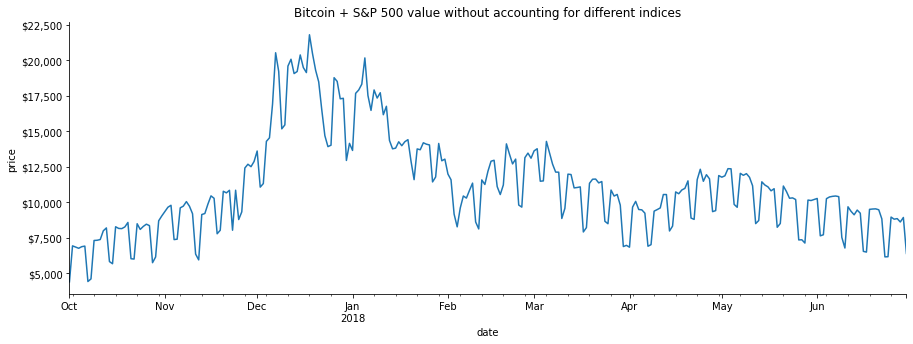

In [40]:
# plot the closing price from Q4 2017 through Q2 2018
ax = portfolio['2017-Q4':'2018-Q2'].plot(
    y='close', figsize=(15, 5), legend=False,
    title='Bitcoin + S&P 500 value without accounting for different indices'
)

# formatting
ax.set_ylabel('price')
ax.yaxis.set_major_formatter(StrMethodFormatter('${x:,.0f}'))
for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)

# show the plot
plt.show()

We need to align the index of the S&P 500 to match bitcoin in order to fix this. We will use the `reindex()` method, but by default we get `NaN` for the values that we don't have data for:

* 위에와 같이 plot이 주기적으로 down되는 현상을 아래 table과 같이 살펴보았다.

In [41]:
sp.reindex(bitcoin.index).head(10).assign(
    day_of_week=lambda x: x.index.day_name()
)

,high,low,open,close,volume,day_of_week
date,,,,,,
2017-01-01,NaN,NaN,NaN,NaN,NaN,Sunday
2017-01-02,NaN,NaN,NaN,NaN,NaN,Monday
2017-01-03,2263.879883,2245.129883,2251.570068,2257.830078,3.770530e+09,Tuesday
2017-01-04,2272.820068,2261.600098,2261.600098,2270.750000,3.764890e+09,Wednesday
2017-01-05,2271.500000,2260.449951,2268.179932,2269.000000,3.761820e+09,Thursday
2017-01-06,2282.100098,2264.060059,2271.139893,2276.979980,3.339890e+09,Friday
2017-01-07,NaN,NaN,NaN,NaN,NaN,Saturday
2017-01-08,NaN,NaN,NaN,NaN,NaN,Sunday
2017-01-09,2275.489990,2268.899902,2273.590088,2268.899902,3.217610e+09,Monday


* table을 보았을 때, sunday와 saturday 즉. 거래가 없는 날 비트코인은 거래가 없는 날에도 거래량에 변동이 있지만 주식과 같은 경우에는 거래소가 문을 열어야 되기 때문에 거래가 없는 날에 줄어드는 현상이 나오게 된다.

So now we have rows for every day of the year, but all the weekends and holidays have `NaN` values. To address this, we can specify how to handle missing values with the `method` argument. In this case, we want to forward-fill, which will put the weekend and holiday values as the value they had for the Friday (or end of trading week) before:

* sp데이터를 bitcoin을 index로 다시 reindex를 해주고, method를 ffill로 해줘서 row word에 있는 걸로 missing을 채워 넣는 방법을 사용해준다. 
근데 아래 table에서 2017-01-01과 2017-01-02는 앞에 데이터가 없기 때문에 ffill을 사용했을 때, 데이터의 값이 채워지지 않는 것을 볼 수 있다.

In [42]:
sp.reindex(bitcoin.index, method='ffill').head(10)\
    .assign(day_of_week=lambda x: x.index.day_name())

,high,low,open,close,volume,day_of_week
date,,,,,,
2017-01-01,NaN,NaN,NaN,NaN,NaN,Sunday
2017-01-02,NaN,NaN,NaN,NaN,NaN,Monday
2017-01-03,2263.879883,2245.129883,2251.570068,2257.830078,3.770530e+09,Tuesday
2017-01-04,2272.820068,2261.600098,2261.600098,2270.750000,3.764890e+09,Wednesday
2017-01-05,2271.500000,2260.449951,2268.179932,2269.000000,3.761820e+09,Thursday
2017-01-06,2282.100098,2264.060059,2271.139893,2276.979980,3.339890e+09,Friday
2017-01-07,2282.100098,2264.060059,2271.139893,2276.979980,3.339890e+09,Saturday
2017-01-08,2282.100098,2264.060059,2271.139893,2276.979980,3.339890e+09,Sunday
2017-01-09,2275.489990,2268.899902,2273.590088,2268.899902,3.217610e+09,Monday


To isolate the changes happening with the forward-filling, we can use the `compare()` method. It shows us the values that differ across identically-labeled dataframes (same names and same columns). Here, we can see that only weekends and holidays (Monday, January 16, 2017 was MLK day) have values forward-filled. Notice that consecutive days have the same values.

* saturday와 같은 경우는 데이터가 이전의 데이터로 채워 졌는데, volume과 같은 경우는 0이 되는게 말이 되고 나머지 값과 같은 것들은 이전의 데이터를 그대로 가지고 오는게 아니라 최종가를 가지고 오는 방법을 사요해주는게 말이 된다고 하심. 

In [43]:
sp.reindex(bitcoin.index)\
    .compare(sp.reindex(bitcoin.index, method='ffill'))\
    .head(10).assign(day_of_week=lambda x: x.index.day_name())

high               low  ... volume               day_of_week
           self        other self  ...   self         other            
date                               ...                                 
2017-01-07  NaN  2282.100098  NaN  ...    NaN  3.339890e+09    Saturday
2017-01-08  NaN  2282.100098  NaN  ...    NaN  3.339890e+09      Sunday
2017-01-14  NaN  2278.679932  NaN  ...    NaN  3.081270e+09    Saturday
2017-01-15  NaN  2278.679932  NaN  ...    NaN  3.081270e+09      Sunday
2017-01-16  NaN  2278.679932  NaN  ...    NaN  3.081270e+09      Monday
2017-01-21  NaN  2276.959961  NaN  ...    NaN  3.524970e+09    Saturday
2017-01-22  NaN  2276.959961  NaN  ...    NaN  3.524970e+09      Sunday
2017-01-28  NaN  2299.020020  NaN  ...    NaN  3.135890e+09    Saturday
2017-01-29  NaN  2299.020020  NaN  ...    NaN  3.135890e+09      Sunday
2017-02-04  NaN  2298.310059  NaN  ...    NaN  3.597970e+09    Saturday

[10 rows x 11 columns]

This isn't perfect though. We probably want 0 for the volume traded and to put the closing price for the open, high, low, and close on the days the market is closed:

* 그래서 아래의 코드에서 최종가로 값을 채워 넣는것을 볼 수 있다.

In [44]:
import numpy as np

sp_reindexed = sp.reindex(bitcoin.index).assign(
    volume=lambda x: x.volume.fillna(0), # put 0 when market is closed
    close=lambda x: x.close.fillna(method='ffill'), # carry this forward
    # take the closing price if these aren't available
    open=lambda x: np.where(x.open.isnull(), x.close, x.open),
    high=lambda x: np.where(x.high.isnull(), x.close, x.high),
    low=lambda x: np.where(x.low.isnull(), x.close, x.low)
)
sp_reindexed.head(10).assign(
    day_of_week=lambda x: x.index.day_name()
)

,high,low,open,close,volume,day_of_week
date,,,,,,
2017-01-01,NaN,NaN,NaN,NaN,0.000000e+00,Sunday
2017-01-02,NaN,NaN,NaN,NaN,0.000000e+00,Monday
2017-01-03,2263.879883,2245.129883,2251.570068,2257.830078,3.770530e+09,Tuesday
2017-01-04,2272.820068,2261.600098,2261.600098,2270.750000,3.764890e+09,Wednesday
2017-01-05,2271.500000,2260.449951,2268.179932,2269.000000,3.761820e+09,Thursday
2017-01-06,2282.100098,2264.060059,2271.139893,2276.979980,3.339890e+09,Friday
2017-01-07,2276.979980,2276.979980,2276.979980,2276.979980,0.000000e+00,Saturday
2017-01-08,2276.979980,2276.979980,2276.979980,2276.979980,0.000000e+00,Sunday
2017-01-09,2275.489990,2268.899902,2273.590088,2268.899902,3.217610e+09,Monday


* 그래서 sunday와 saturday의 값이 채워진 것을 볼 수 있다.

If we create a visualization comparing the reindexed data to the first attempt, we see how reindexing helped maintain the asset value when the market was closed:

* 수정을 한다음에 그림을 다시한번 살펴본다.

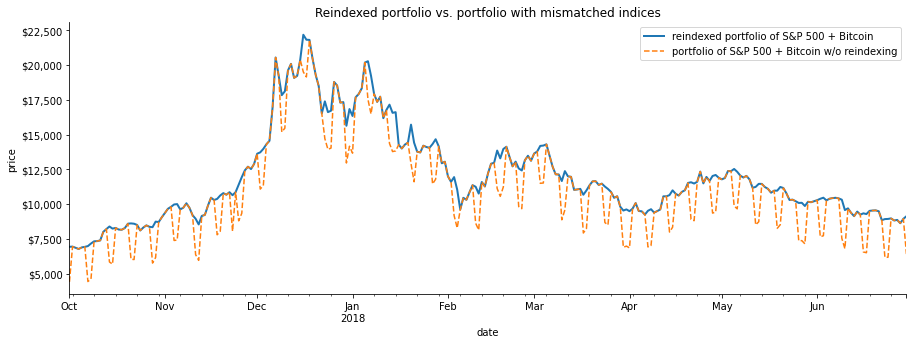

In [45]:
# every day's closing price = S&P 500 close adjusted for market closure + Bitcoin close (same for other metrics)
fixed_portfolio = sp_reindexed + bitcoin

# plot the reindexed portfolio's closing price from Q4 2017 through Q2 2018
ax = fixed_portfolio['2017-Q4':'2018-Q2'].plot(
    y='close', label='reindexed portfolio of S&P 500 + Bitcoin', figsize=(15, 5), linewidth=2, 
    title='Reindexed portfolio vs. portfolio with mismatched indices'
)

# add line for original portfolio for comparison
portfolio['2017-Q4':'2018-Q2'].plot(
    y='close', ax=ax, linestyle='--', label='portfolio of S&P 500 + Bitcoin w/o reindexing'
)

# formatting
ax.set_ylabel('price')
ax.yaxis.set_major_formatter(StrMethodFormatter('${x:,.0f}'))
for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)

# show the plot
plt.show()

* 처리를 해주지 않는 것은 주황색으로 해서 down이 되는 것을 볼 수 있었는데, 수정한 것을 down이 일어나지 않는 것을 볼 수 있다. 

<hr>
<div>
    <a href="./2-using_the_weather_api.ipynb">
        <button>&#8592; Previous Notebook</button>
    </a>
    <a href="./4-reshaping_data.ipynb">
        <button style="float: right;">Next Notebook &#8594;</button>
    </a>
</div>
<hr>